In this notebook we go through each step of audio processing to gemerate midi notes for guitar solo from audio input

# Environment setup

First install required packages.

In [ ]:
!pip install spleeter noisereduce librosa pydub

Then import packages, connect to google drive and specify file path

In [1]:
import noisereduce as nr
import librosa
import soundfile as sf
from pydub import AudioSegment
from IPython.display import Audio, display
from spleeter.separator import Separator
import os
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')

# here replace with desired file path
original_audio = '/content/gdrive/MyDrive/test/SCOM.mp3'
segment = f"{original_audio.split('.')[0]}/segment.mp3"
segment_wav = f"{segment.split('.')[0]}.wav"


Mounted at /content/gdrive


# Audio loading and sampling





We can work with the input file for now and later switch to live feed

In [2]:
def sample_audio(input_file, output_file, start_time, end_time):
    # sample the input audio file from start_time to end_time and saves the
    # segment to output_file
    # Load the MP3 file
    audio = AudioSegment.from_mp3(input_file)

    # Define start and end times for the segment (in milliseconds)
    start_time = start_time * 1000  # Convert to milliseconds
    end_time = end_time * 1000  # Convert to milliseconds

    # Slice the audio segment
    audio_segment = audio[start_time:end_time]


    # Save the audio segment as a new MP3 file
    audio_segment.export(output_file, format="mp3")

    # Convert to raw data for playback to check if we got the right segment
    display(Audio(output_file, autoplay=False))


def to_wav(input_file):
    # convert mp3 to wav
    audio = AudioSegment.from_mp3(input_file)
    audio.export(f"{input_file.split('.')[0]}.wav", format="wav")

def get_sample_rate(input_file):
    # get the sample rate of the input file
    audio = AudioSegment.from_mp3(input_file)
    return audio.frame_rate

def play_audio(input_file):
    # play the input file
    display(Audio(input_file, autoplay=False))


In [3]:
# in this example we sample the guitar intro of sweet child o mine
sample_audio(original_audio, segment, 0, 16)
to_wav(segment)
print(f"Sample rate: {get_sample_rate(segment_wav)}")


Sample rate: 48000


# Preprocess

## noise removal

Although by ear it sounds cleaner, for many guitar effects with heavy distortions this step removes too much information as well.

In [4]:
# reduce background noise
def reduce_noise(input_file):
    # Load audio
    audio, sr = librosa.load(input_file, sr=None)
    # Perform noise reduction
    reduced_noise_audio = nr.reduce_noise(y=audio, sr=sr)

    # Save the processed audio
    output_file = f"{input_file.split('.')[0]}_noiserm.wav"
    sf.write(output_file, reduced_noise_audio, sr)

    # next we could play the og file and cleaned file for comparison
    play_audio(input_file)
    play_audio(output_file)
    return output_file



In [5]:
segment_nr = reduce_noise(segment_wav)

## separate tracks

The next step in preprocess is done by `spleeter.separator.Separator`.\
 It uses a pretrained ML model to separate the instrumet tracks from the source.

In [ ]:
def separate_audio(input_file, output_path, stems="2stems"):
    # Create a separator with the specified number of stems.
    # Options are '2stems', '4stems', or '5stems'.
    separator = Separator(f'spleeter:{stems}')

    # Use the separator on the input file.
    separator.separate_to_file(input_file, output_path)

# Define the input audio file and the output directory
input_file = '/content/gdrive/MyDrive/test/flowers.mp3'
output_path = f'/content/gdrive/MyDrive/test/'

print(os.environ)
# Separate the audio file into different components
separate_audio(input_file, output_path, stems='2stems')

# The output will be in the specified directory with different stems as audio files.



environ({'SHELL': '/bin/bash', 'NV_LIBCUBLAS_VERSION': '12.2.5.6-1', 'NVIDIA_VISIBLE_DEVICES': 'all', 'COLAB_JUPYTER_TRANSPORT': 'ipc', 'NV_NVML_DEV_VERSION': '12.2.140-1', 'NV_CUDNN_PACKAGE_NAME': 'libcudnn8', 'CGROUP_MEMORY_EVENTS': '/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events', 'NV_LIBNCCL_DEV_PACKAGE': 'libnccl-dev=2.19.3-1+cuda12.2', 'NV_LIBNCCL_DEV_PACKAGE_VERSION': '2.19.3-1', 'VM_GCE_METADATA_HOST': '169.254.169.253', 'HOSTNAME': '89db23fedc35', 'LANGUAGE': 'en_US', 'TBE_RUNTIME_ADDR': '172.28.0.1:8011', 'COLAB_TPU_1VM': '', 'GCE_METADATA_TIMEOUT': '3', 'NVIDIA_REQUIRE_CUDA': 'cuda>=12.2 brand=tesla,driver>=470,driver<471 brand=unknown,driver>=470,driver<471 brand=nvidia,driver>=470,driver<471 brand=nvidiartx,driver>=470,driver<471 brand=geforce,driver>=470,driver<471 brand=geforcertx,driver>=470,driver<471 brand=quadro,driver>=470,driver<471 brand=quadrortx,driver>=470,driver<471 brand=titan,driver>=470,driver<471 brand=titanrtx,driver>=470,dr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


INFO:spleeter:Downloading model archive https://github.com/deezer/spleeter/releases/download/v1.4.0/2stems.tar.gz


INFO:spleeter:Downloading model archive https://github.com/deezer/spleeter/releases/download/v1.4.0/2stems.tar.gz


INFO:spleeter:Validating archive checksum


INFO:spleeter:Validating archive checksum


INFO:spleeter:Extracting downloaded 2stems archive


INFO:spleeter:Extracting downloaded 2stems archive


INFO:spleeter:2stems model file(s) extracted


INFO:spleeter:2stems model file(s) extracted
Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead
Instructions for updating:
Colocations handled automatically by placer.


INFO:spleeter:File /content/gdrive/MyDrive/test/flowers/vocals.wav written succesfully


INFO:spleeter:File /content/gdrive/MyDrive/test/flowers/vocals.wav written succesfully


INFO:spleeter:File /content/gdrive/MyDrive/test/flowers/accompaniment.wav written succesfully


INFO:spleeter:File /content/gdrive/MyDrive/test/flowers/accompaniment.wav written succesfully


# audio visualization

We could visualize the song data for each track.

## unmodified spectrogram

In [6]:
def plot_waveform_and_spectrogram(audio_path, title):
    # this is the most barebone module
    # to create specttrogram, need tuning on top of this

    # Load the audio file
    y, sr = librosa.load(audio_path, sr=None)
    plt.figure(figsize=(12, 6))

    # Plot waveform
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform of {title}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Plot spectrogram
    plt.subplot(2, 1, 2)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Spectrogram of {title}')
    plt.tight_layout()

    plt.show()

In [7]:
# Define paths to the original and separated stems
vocals_path = f"{original_audio.split('.')[0]}/vocals.wav"
bass_path = f"{original_audio.split('.')[0]}/bass.wav"
drums_path = f"{original_audio.split('.')[0]}/drums.wav"
piano_path = f"{original_audio.split('.')[0]}/piano.wav"
other_path = f"{original_audio.split('.')[0]}/other.wav"
bz_path = f"{original_audio.split('.')[0]}/accompaniment.wav"

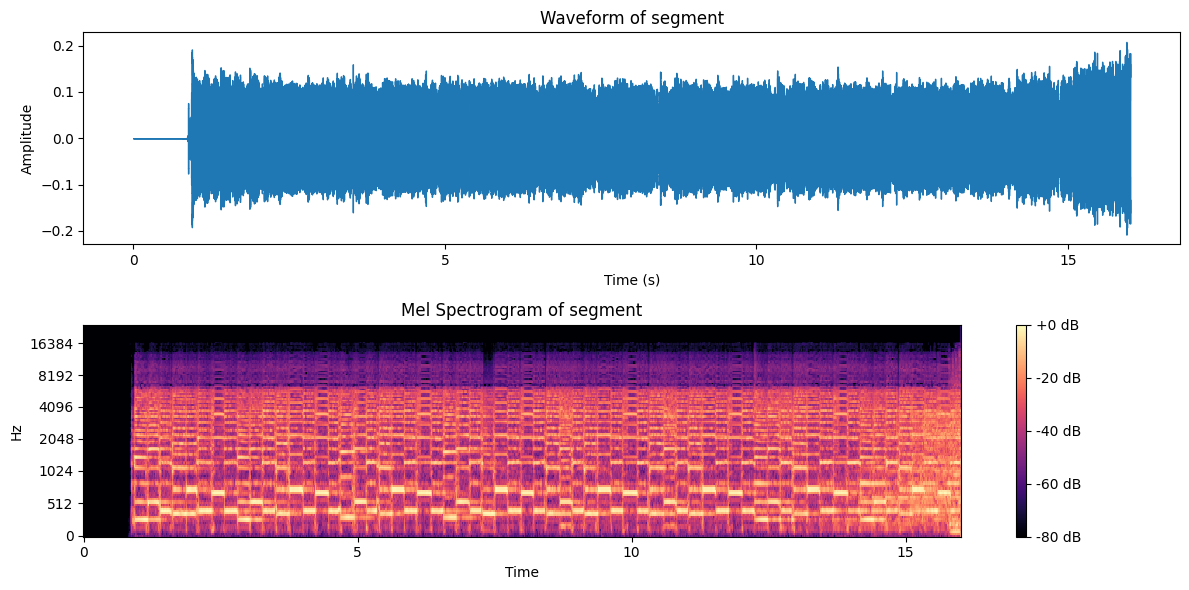

In [7]:
# Plotting the waveform and spectrogram of the segment
plot_waveform_and_spectrogram(segment, 'segment')

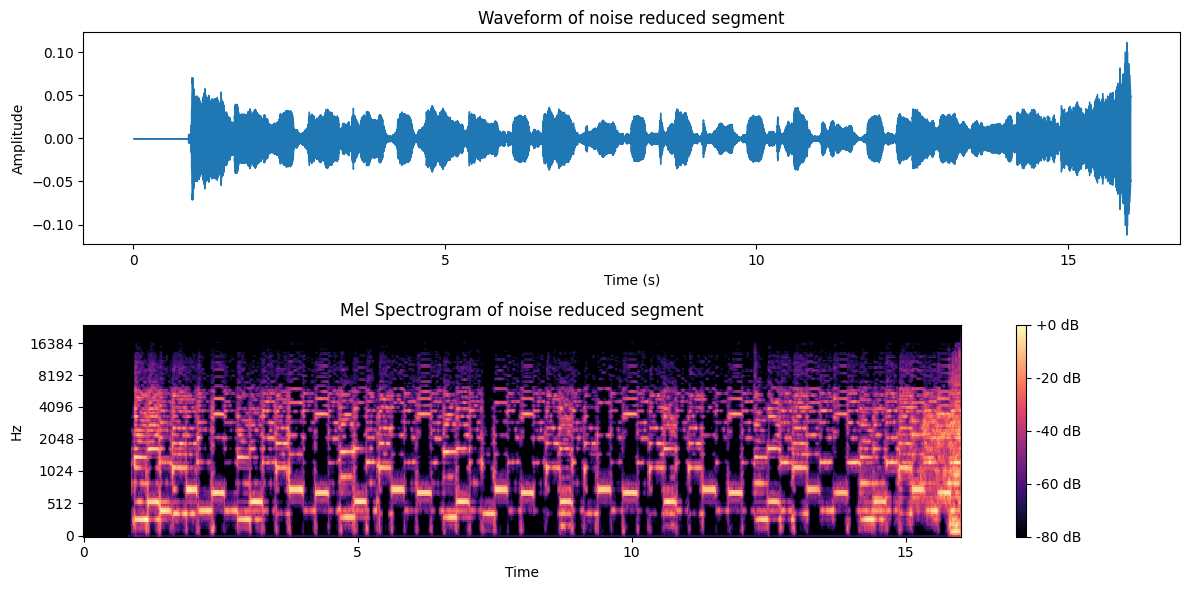

In [16]:
plot_waveform_and_spectrogram(segment_nr, 'noise reduced segment')

Lokking at the graph the noise reduction algorithm removes too much information

# spectrogram tweaking

we can further tweak the spectrogram so that its easier to find midi notes.

## beat alignment

Although we could clearly see some semblance of note in the spectrogram, the default output does not look clear. \
The first idea is to align the peroid for fourier transform with the beats of music.\
We use `librosa.beat.beatrack` for BPM estimation istead of manual input.

In [58]:
# think of ways to tune the spectrogram
# should align the bpm and the step of the spectrogram
# so we align steps with beats

def compute_spectrogram(audio_path, sr=None):
    # instead of using the librosa included feateures,
    # we could tweak the parameters for more resolution

    # Load audio
    y, sr = librosa.load(audio_path, sr=sr)

    # find the bpm estimate by librosa
    BPM, beats = librosa.beat.beat_track(y=y, sr=sr)

    beats_per_second = BPM / 60
    time_per_beat = 1 / beats_per_second  # in seconds
    samples_per_beat = sr * time_per_beat


    # Compute the spectrogram
    n_fft = int(samples_per_beat/8)  # window size for the FFT
    print(f"n_fft: {n_fft}")
    hop_length = int(samples_per_beat / 8)  # half a beat overlap
    D = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))

    # Convert amplitude to dB
    S_DB = librosa.amplitude_to_db(D, ref=np.max)

    # Compute Mel spectrogram
    # S = librosa.feature.melspectrogram(y=y, sr=sr)
    # S_DB = librosa.power_to_db(S, ref=np.max)
    return S_DB, sr, n_fft, hop_length


def beat_aligned_spectrogram(audio_path):
    # compute spectrogram
    S_DB, sr, n_fft, hop_length = compute_spectrogram(audio_path)

    # Plot the spectrogram
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram of {audio_path.split("/")[-1]} aligned with beats')
    plt.show()


def plot_spectrograms(audio_paths, titles):
    # plot spectrograms side by side for clear viewing
    plt.figure(figsize=(15, 10))
    n = len(audio_paths)

    for i, (path, title) in enumerate(zip(audio_paths, titles), start=1):
        S_DB, sr, n_fft, hop_length = compute_spectrogram(path)
        plt.subplot(n, 1, i)
        librosa.display.specshow(S_DB, sr=sr,n_fft=n_fft, hop_length=hop_length, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel Spectrogram of {title}')

    plt.tight_layout()
    plt.show()

<ipython-input-58-b3347120253d>:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n_fft = int(samples_per_beat/8)  # window size for the FFT
<ipython-input-58-b3347120253d>:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hop_length = int(samples_per_beat / 8)  # half a beat overlap


n_fft: 2880


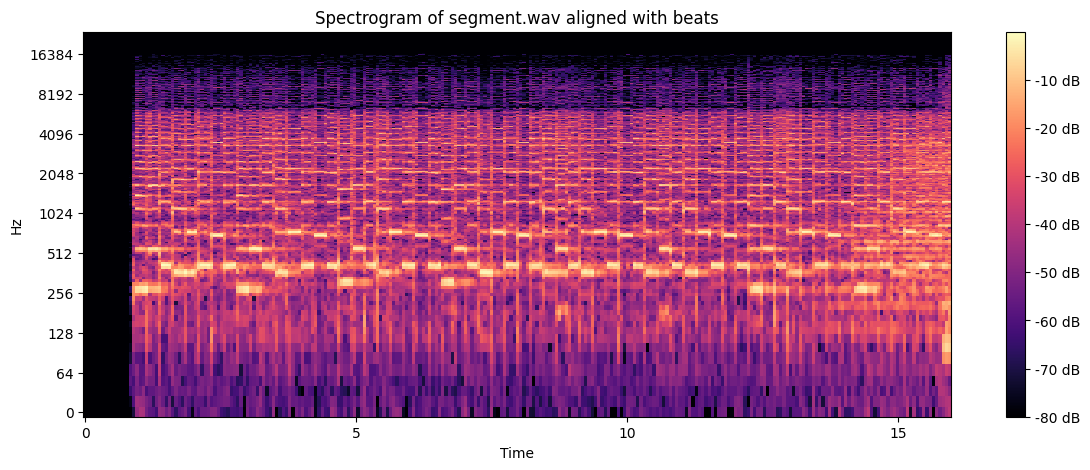

In [59]:
# List of paths to the audio files (original and stems)
# audio_paths = [
#     original_audio,
#     vocals_path,
#     bass_path,
#     drums_path,
#     piano_path,
#     other_path
# ]
audio_paths = [
    segment_wav,
    segment_nr
]
# audio_paths.append(f'{audio_paths[0].split(".")[0]}_rn.wav')
# Corresponding titles for the audio tracks
# titles = ['Original', 'Vocals', 'Bass', 'Drums','Piano', 'Other']
titles = ["og", 'nr']
# plot_spectrograms(audio_paths, titles)
beat_aligned_spectrogram(segment_wav)

## filter

Also, we could use use a simple filter to only focus on the higest values in the spectrogram.\
Also, we could ignore the frequencies outside of a guitar's voicing range for now. \
However, data on higher frequencies could be helpful as indication of harmonics.

In [56]:
def filtered_spectrogram(audio_path):
    # compute spectrogram
    S_DB, sr, n_fft, hop_length = compute_spectrogram(audio_path)
    # display some stats of the S_DB matrix
    print(f"S_DB shape: {S_DB.shape}")
    print(f"S_DB max: {S_DB.max()}")
    print(f"S_DB min: {S_DB.min()}")
    print(f"S_DB mean: {S_DB.mean()}")
    print(f"S_DB std: {S_DB.std()}")
    # also show the 25th and 75th percentile
    print(f"S_DB 25th percentile: {np.percentile(S_DB, 25)}")
    print(f"S_DB 75th percentile: {np.percentile(S_DB, 75)}")

    # filter the matrix and set every value below 99th percentile to min
    S_DB[S_DB < np.percentile(S_DB, 99)] = S_DB.min()

    # Plot the spectrogram
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram of {audio_path.split("/")[-1]} aligned with beats')
    plt.show()


<ipython-input-54-8df64ac6472c>:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n_fft = int(samples_per_beat/8)  # window size for the FFT
<ipython-input-54-8df64ac6472c>:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hop_length = int(samples_per_beat / 16)  # half a beat overlap


n_fft: 2880
S_DB shape: (1441, 534)
S_DB max: -3.814697265625e-06
S_DB min: -80.0
S_DB mean: -65.83270263671875
S_DB std: 17.99460792541504
S_DB 25th percentile: -80.0
S_DB 75th percentile: -53.30522155761719


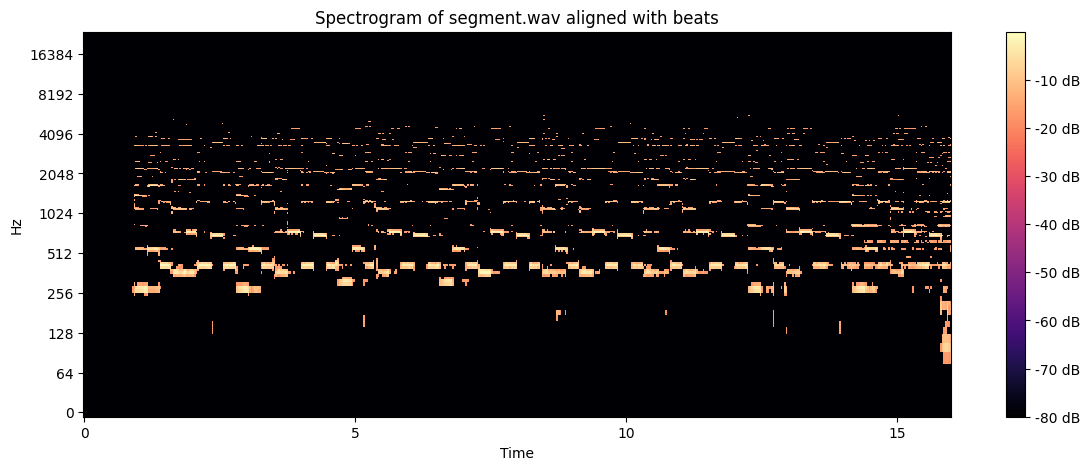

In [57]:
filtered_spectrogram(segment_wav)

the tweaked spectrograms looks promising and we can sort of see the vague highligts that resembles notes.

# pitch detection

Next, we detect the pitch and generate midi notes.



In [ ]:
# we could continue from the spectrogram


In [43]:
!pip install mido MIDIUtil python-rtmidi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.1/304.1 kB 13.9 MB/s eta 0:00:00


In [11]:
from midiutil import MIDIFile

In [12]:
# Function to convert pitch to MIDI note number
def hz_to_midi(hz):
    return int(69 + 12 * np.log2(hz / 440.0))

# Load audio segment (use librosa to load the audio)
audio_file = segment_wav  # Replace with your audio file path
y, sr = librosa.load(audio_file, sr=None)

# Detect pitch over time using librosa
pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr)

# MIDI file setup
midi = MIDIFile(1)  # Single track
track = 0  # Track number
time = 0  # Start at the beginning
midi.addTrackName(track, time, "Track 1")
BPM, beats = librosa.beat.beat_track(y=y, sr=sr)


midi.addTempo(track, time, BPM)  # Set a default tempo (bpm)

# Extract the MIDI notes from pitch
times = librosa.times_like(pitches, sr=sr)
for t in range(pitches.shape[1]):
    pitch = pitches[:, t].max()  # Get the highest pitch in the frame
    if pitch > 0:  # Only use non-zero pitches
        midi_note = hz_to_midi(pitch)
        duration = 0.1  # Set a default note duration (adjust as needed)
        velocity = 100  # Note velocity (volume)
        midi.addNote(track, 0, midi_note, times[t], duration, velocity)

# Save MIDI file
midi_file = f"{audio_file.split('.')[0]}.mid"
with open(midi_file, "wb") as output_file:
    midi.writeFile(output_file)

print(f"MIDI file has been created: {midi_file}")

MIDI file has been created: /content/gdrive/MyDrive/test/SCOM/segment.mid


# midi playback

In [50]:
!pip install pyfluidsynth midi2audio


In [ ]:
!sudo apt-get install fluidsynth

In [ ]:
!fluidsynth -ni sound_font.sf2 input.mid -F output.wav -r 44100

In [52]:
from midi2audio import FluidSynth

soundfont = '/content/gdrive/MyDrive/test/acoustic.sf2'
midi_wav = f"{midi_file.split('.')[0]}_midi.wav"

# Initialize FluidSynth
fs = FluidSynth()

# Play the MIDI file and render it to WAV
fs.midi_to_audio(midi_file, midi_wav)

# Stop the synthesizer
print(f"Conversion complete: {midi_wav}")


Conversion complete: /content/gdrive/MyDrive/test/SCOM/segment_midi.wav


In [53]:
play_audio(midi_wav)

# Now we can further process the music file for our ML pipeline


# brainstorm section


consider the sound envelope for guitar recognition \
I would assume differnt guitar technique would cause this to differ but need data to confirm.
![picture](https://www.audiolabs-erlangen.de/resources/MIR/FMP/data/C1/FMP_C1_F22a-23.png)

also need to consider harmonic partial when implementing note recogition


what to do with vibrato/slide/bend/harmonics?